In [13]:
from keras.utils import np_utils
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import Callback, EarlyStopping
from keras import backend as K
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,Dropout,AveragePooling2D
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import cv2
from keras.utils.vis_utils import plot_model

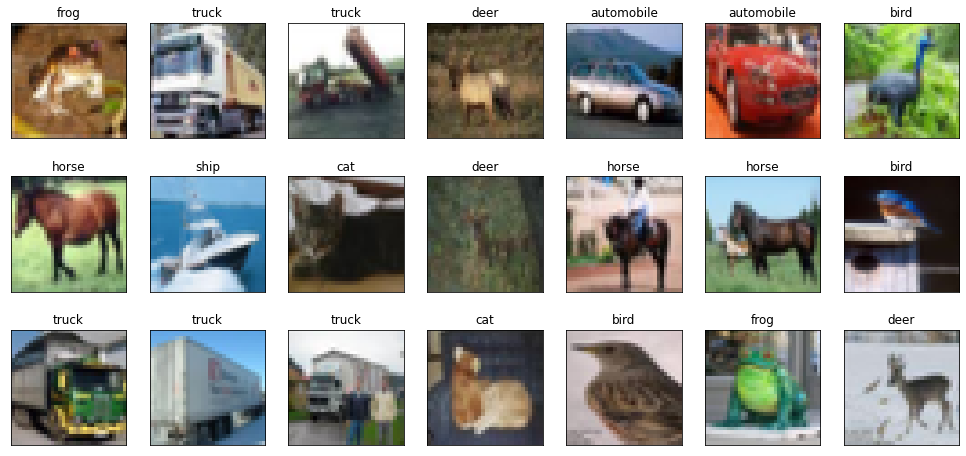

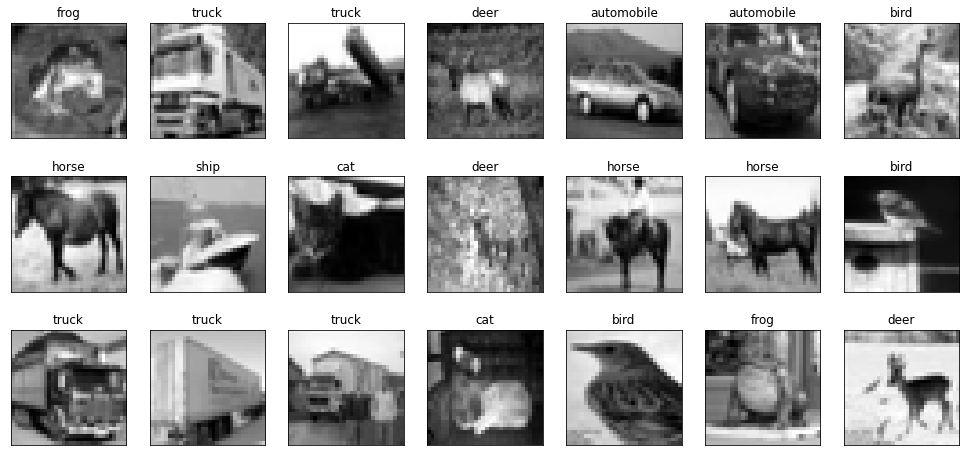

In [2]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder


(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#Displaying images
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(17, 8))
index = 0
for i in range(3):
    for j in range(7):
        axes[i,j].set_title(labels[y_train[index][0]])
        axes[i,j].imshow(X_train[index])
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()
X_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_train])
X_test = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_test])
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(17, 8))
index = 0
for i in range(3):
    for j in range(7):
        axes[i,j].set_title(labels[y_train[index][0]])
        axes[i,j].imshow(X_train[index], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

X_train  = X_train/255
X_test  = X_test/255
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)
X_val,X_test,y_val,y_test = tts(X_test,y_test,test_size = 0.5)

In [14]:
def create_lenet_model(p):
    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(32,32,1), padding='same'))
    tf.keras.layers.LayerNormalization(trainable=True)
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
    model.add(BatchNormalization(trainable=True))
    model.add(Dropout(p))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
    model.add(Dropout(p))
    model.add(BatchNormalization(trainable=True))
    model.add(Flatten())
    model.add(Dense(84, activation='relu'))
    model.add(Dropout(p))
    model.add(BatchNormalization(trainable=True))
    model.add(Dense(10, activation='softmax'))
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)    
    return model

model = create_lenet_model(0.4)

2021-12-15 19:01:04.513906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 19:01:04.525456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 19:01:04.525801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 19:01:04.526877: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [16]:
import numpy as np

def run_model(policy,no_dropout):
    val_loss = []
    training_loss = []
    dropouts = []
    if policy:
        p =0
    else:
        if no_dropout:
            p = 0
        else:
            p = 0.3
    dropouts.append(p)
    epochs = 100
    lookback = np.ceil(0.05*epochs)
    best_val_loss = 1000
    for i in range(1,epochs+1):
        print(f"Epoch {i}")
        if i == 1 :
            print("initial case")
            model = create_lenet_model(p)
            model.compile(optimizer= 'adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
            history=model.fit(X_train,y_train ,epochs=1, batch_size=64, validation_data=(X_val,y_val), verbose=1)
            model.save_weights('modelsofar.hd5')
            val_loss.append(history.history['val_loss'][0])
            training_loss.append(history.history['loss'][0])
            continue

        if policy and not (i+1)%lookback:
            avg_val = np.mean([loss for loss in val_loss[-5:]])
            avg_train = np.mean([loss for loss in training_loss[-5:]])
            loss_diff = abs(avg_train-avg_val)
            percentage_diff = loss_diff/avg_train
            p = percentage_diff
            if p>0.5:
                p = 0.5
        
        print(f'rate {p}')
        model = create_lenet_model(p)
        model.compile(optimizer= 'adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
        model.load_weights('modelsofar.hd5')   
        dropouts.append(p)
        history=model.fit(X_train,y_train ,epochs=1, batch_size=128, validation_data=(X_val,y_val), verbose=0)
        model.save_weights('modelsofar.hd5')
        if history.history['val_loss'][0]<=best_val_loss:
            best_val_loss = history.history['val_loss'][0]
            model.save_weights('best_modelsofar.hd5')
        val_loss.append(history.history['val_loss'][0])
        training_loss.append(history.history['loss'][0])
    
    model.load_weights('best_modelsofar.hd5')
    return model,training_loss,val_loss,dropouts

In [17]:
import matplotlib.pyplot as plt

policy_model,policy_train,policy_val,varying_dropouts = run_model(True,False)
model,train,val,_ = run_model(False,False)
nodropout_model,nodropout_train,nodropout_val,_ = run_model(False,True)

Epoch 1
initial case
782/782 [==============================] - 6s 7ms/step - loss: 1.5884 - accuracy: 0.4390 - val_loss: 1.3873 - val_accuracy: 0.5084
Epoch 2
rate 0
Epoch 3
rate 0
Epoch 4
rate 0.06439309721457451
Epoch 5
rate 0.06439309721457451
Epoch 6
rate 0.06439309721457451
Epoch 7
rate 0.06439309721457451
Epoch 8
rate 0.06439309721457451
Epoch 9
rate 0.3161409878995815
Epoch 10
rate 0.3161409878995815
Epoch 11
rate 0.3161409878995815
Epoch 12
rate 0.3161409878995815
Epoch 13
rate 0.3161409878995815
Epoch 14
rate 0.04756174717770638
Epoch 15
rate 0.04756174717770638
Epoch 16
rate 0.04756174717770638
Epoch 17
rate 0.04756174717770638
Epoch 18
rate 0.04756174717770638
Epoch 19
rate 0.5
Epoch 20
rate 0.5
Epoch 21
rate 0.5
Epoch 22
rate 0.5
Epoch 23
rate 0.5
Epoch 24
rate 0.05053924925737754
Epoch 25
rate 0.05053924925737754
Epoch 26
rate 0.05053924925737754
Epoch 27
rate 0.05053924925737754
Epoch 28
rate 0.05053924925737754
Epoch 29
rate 0.5
Epoch 30
rate 0.5
Epoch 31
rate 0.5
Epoch

Vanilla accuracy 0.7302
Vanilla f1 0.7312543927377655
Dynamic accuracy 0.7302
Dynamic f1 0.7312543927377655
No Dropout accuracy 0.7302
No Dropout f1 0.7312543927377655


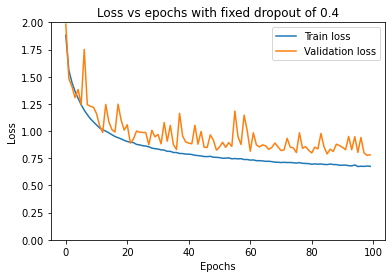

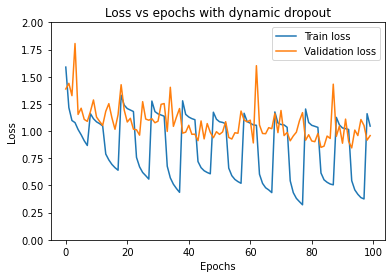

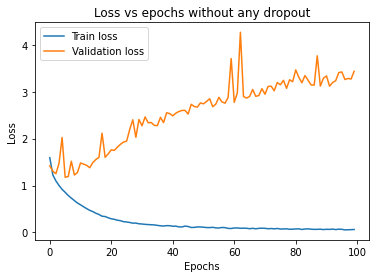

In [12]:
from sklearn.metrics import accuracy_score,f1_score
import json

epochs = 100
with open('./cifar10/cifar10.txt') as f:
    json_data = json.load(f)

train = json_data['Vanilla']['train_loss']
val = json_data['Vanilla']['val_loss']
accuracy = json_data['Vanilla']['accuracy']
f1 = json_data['Vanilla']['f1']

policy_train = json_data['Dynamic']['train_loss']
policy_val = json_data['Dynamic']['val_loss']
accuracy_policy = json_data['Dynamic']['accuracy']
f1_policy = json_data['Dynamic']['f1']

nodropout_train = json_data['NoDrop']['train_loss']
nodropout_val = json_data['NoDrop']['val_loss']
accuracy_nodropout = json_data['NoDrop']['accuracy']
f1_nodropout = json_data['NoDrop']['f1']


fig1 = plt.figure()
plt.title("Loss vs epochs with fixed dropout of 0.4")
plt.ylim(0,2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(epochs),train,label = 'Train loss')
plt.plot(range(epochs),val, label = 'Validation loss')
plt.legend()
plt.savefig('./cifar10/nopolicy')
fig1.show()

fig2 = plt.figure()
plt.title("Loss vs epochs with dynamic dropout")
plt.ylim(0,2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(epochs),policy_train,label = 'Train loss')
plt.plot(range(epochs),policy_val, label = 'Validation loss')
plt.legend()
plt.savefig('./cifar10/policy')
fig2.show()

fig3 = plt.figure()
plt.title("Loss vs epochs without any dropout")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(epochs),nodropout_train,label = 'Train loss')
plt.plot(range(epochs),nodropout_val, label = 'Validation loss')
plt.legend()
plt.savefig('./cifar10/nodropout')
fig3.show()

# fig4 = plt.figure()
# plt.ylim(0,0.5)
# plt.title("Dropout variation across epochs")
# plt.xlabel('Epochs')
# plt.ylabel('Dropout rate')
# plt.plot(range(epochs),varying_dropouts,color = 'r')
# plt.savefig('./cifar10/dropouts')
# fig4.show()




# pred = model.predict(X_test)
# pred_classes = np.argmax(pred,axis=1)
# truth = np.argmax(y_test,axis=1)
# f1 = f1_score(pred_classes,truth,average='macro')
# accuracy = accuracy_score(pred_classes,truth)
print(f"Vanilla accuracy {accuracy}")
print(f"Vanilla f1 {f1}")

# pred = policy_model.predict(X_test)
# pred_classes = np.argmax(pred,axis=1)
# truth = np.argmax(y_test,axis=1)
# f1_policy = f1_score(pred_classes,truth,average='macro')
# accuracy_policy = accuracy_score(pred_classes,truth)
print(f"Dynamic accuracy {accuracy_policy}")
print(f"Dynamic f1 {f1_policy}")


# pred = nodropout_model.predict(X_test)
# pred_classes = np.argmax(pred,axis=1)
# truth = np.argmax(y_test,axis=1)
# f1_nodropout = f1_score(pred_classes,truth,average='macro')
# accuracy_nodropout = accuracy_score(pred_classes,truth)
print(f"No Dropout accuracy {accuracy_nodropout}")
print(f"No Dropout f1 {f1_nodropout}")

scores = {
          'Dynamic':{
                    'accuracy':accuracy_policy,
                    'f1':f1_policy,
                    'train_loss':policy_train,
                    'val_loss':policy_val
                  },
          'Vanilla':{
                    'accuracy':accuracy,
                    'f1':f1,
                    'train_loss':train,
                    'val_loss':val
          },
        'NoDrop':{
                    'accuracy':accuracy_nodropout,
                    'f1':f1_nodropout,
                    'train_loss':nodropout_train,
                    'val_loss':nodropout_val
          },
         }
          
output_string = json.dumps(scores)

with open("cifar10/cifar10.txt","w+") as file:
    file.write(output_string)